In [186]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, KFold
import warnings 
import joblib
warnings.filterwarnings('ignore')

In [187]:
df = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [188]:
df.shape

(301, 9)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [190]:
df.describe(include=['number'])

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [191]:
df.describe(include=['object'])

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


In [192]:
df.isnull().values.any()

False

In [193]:
#high number of car names. better to drop:
#one-hot encoding would create 98 new binary features, potentially leading to a sparse dataset
#model might learn patterns specific to individual car names that don't generalize well
df.drop('Car_Name', axis=1, inplace=True)
df.head(2)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0


In [194]:
#better to have an age column relative to max year with an intercept of 1, instead of year
#relative measure vs absolute measure
max_date = df['Year'].max()
df['cars_age'] = max_date - df['Year'] + 1
df.drop('Year', axis = 1, inplace=True)
df.head(2)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,cars_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6


# Outlier Handling

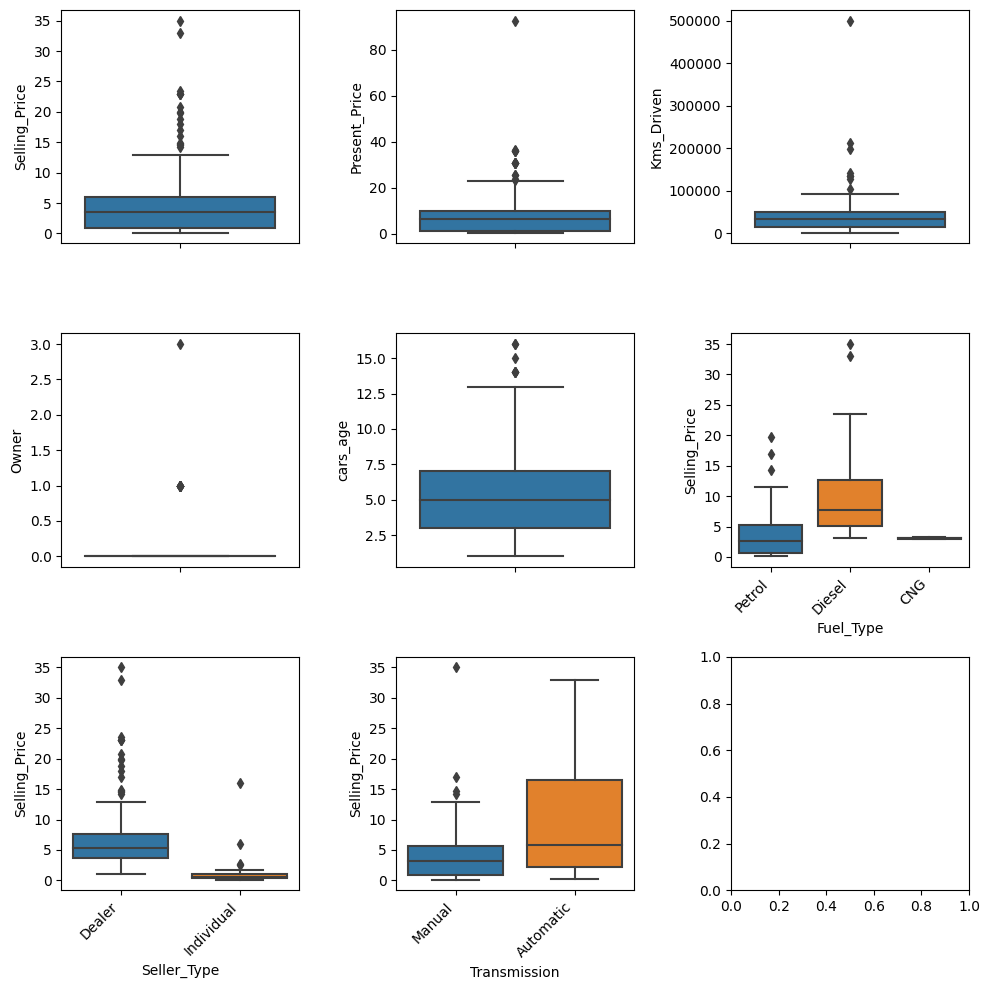

In [195]:
#boxplot outliers
#plot objects boxplots relative to price
numeric_columns = df.select_dtypes(include=['number']).columns
object_columns = df.select_dtypes(include=['object']).columns
all_columns = list(numeric_columns) + list(object_columns)

n_cols = 3
n_rows = (len(all_columns) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

axes = axes.flatten()

for i, column in enumerate(all_columns):
    if df[column].dtype in ['int64', 'float64', 'float32']:
        sns.boxplot(data=df, y=column, ax=axes[i])
    else:
        numeric_col = numeric_columns[0]  #plot relative to selling_price
        sns.boxplot(data=df, x=column, y=numeric_col, ax=axes[i])
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [196]:
#Use the IQR rule to find outliers 
#1. find median, 
#2. find first (Q1) and third quartiles (Q3), 
#3. IQR = Q3 - Q1 
#4. fence = 1.5(IQR)
#5. Q1 - fence gives lower fence for outliers less than lower fence 
#6. Q3 + fence gives higher fence for outliers greater than higher fence 

#for object columns, for each category within the column, we need to use selling price as 
#a metric to measure the relative selling price based on the category 
#e.g.flag outliers for prices for diesel (diesel is a category in fuel_type col)

outlier_indices = []
target = 'Selling_Price'

numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
 
for col in numeric_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = (q3 - q1)
    minimum = q1 - (1.5 * iqr)
    maximum = q3 + (1.5 * iqr)

    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outlier_indices.extend(outlier_samples.index.to_list())

for col in categorical_columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = (q3 - q1)
        minimum = q1 - (1.5 * iqr)
        maximum = q3 + (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outlier_indices.extend(outlier_samples.index.to_list())
    

outlier_indices = list((set(outlier_indices)))
numeric_columns, categorical_columns, len(outlier_indices)

(Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner', 'cars_age'], dtype='object'),
 Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'),
 38)

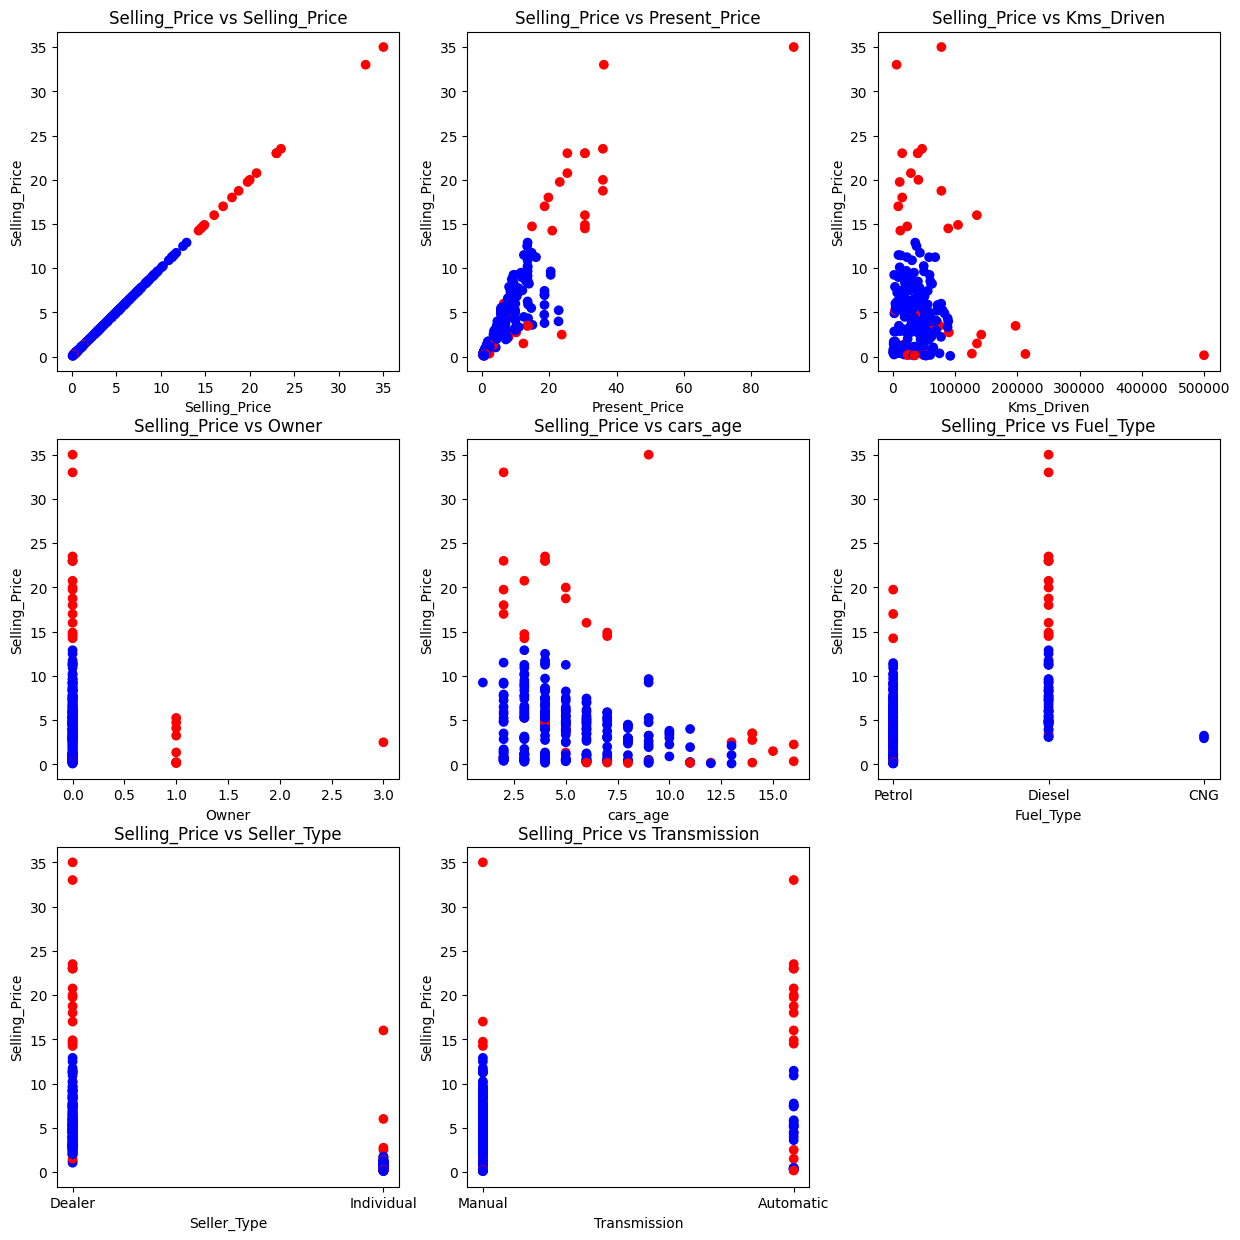

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [197]:
#plot outliers
df_plot = df.copy()
df_plot['Outlier'] = 'No'
df_plot.loc[outlier_indices, 'Outlier'] = 'Yes'

n_numeric_cols = len(numeric_columns)
n_categorical_cols = len(categorical_columns)
n_total_cols = n_numeric_cols + n_categorical_cols

n_cols = 3
n_rows = (n_total_cols + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    plt.figure(figsize=(5, 5))
    ax.scatter(df_plot[col], df_plot[target], c=df_plot['Outlier'].apply(lambda x: 'red' if x == 'Yes' else 'blue'), label='Outlier')
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs {col}')

for i, col in enumerate(categorical_columns):
    ax = axes[n_numeric_cols + i]
    plt.figure(figsize=(5, 5))
    for cat in df_plot[col].unique():
        subset = df_plot[df_plot[col] == cat]
        ax.scatter(subset[col], subset[target], label=f'{col} = {cat}', c=subset['Outlier'].apply(lambda x: 'red' if x == 'Yes' else 'blue'))
        [ax.axis('off') for ax in axes.flatten()[len(numeric_columns) + len(categorical_columns):]]
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs {col}')
plt.tight_layout()
plt.show()

In [198]:
#Outlier Capping
df1 = df.copy()
df1 = df1[df1['Kms_Driven'] <= 400000]
df1 = df1[df1['Selling_Price'] <= 33]

df1['Selling_Price'].max(), df1['Kms_Driven'].max()

(33.0, 213000)

# **EDA**

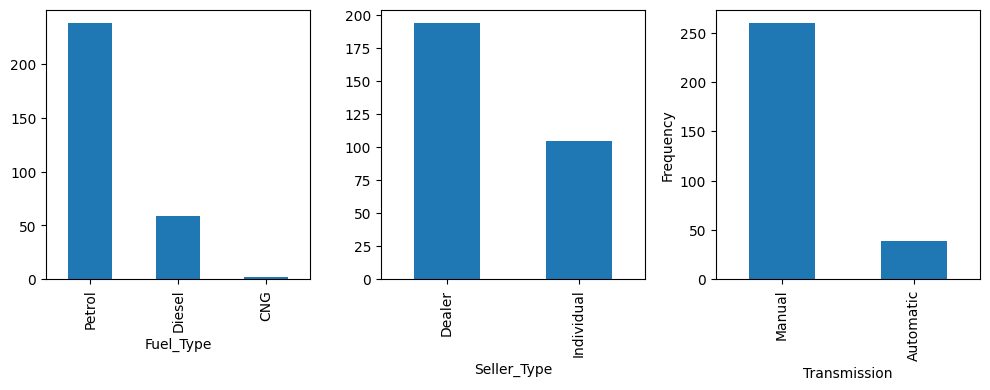

In [199]:
#Categorical Variables Univariate Analysis - examining the frequency distribution of each category within a categorical column
cat_columns = df1.select_dtypes(include=['object']).columns
cat_columns.to_list()

n_cols = 3
n_rows = (len(cat_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

for i, column in enumerate(cat_columns):
    df1[column].value_counts().plot(kind='bar', ax=axes[i])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

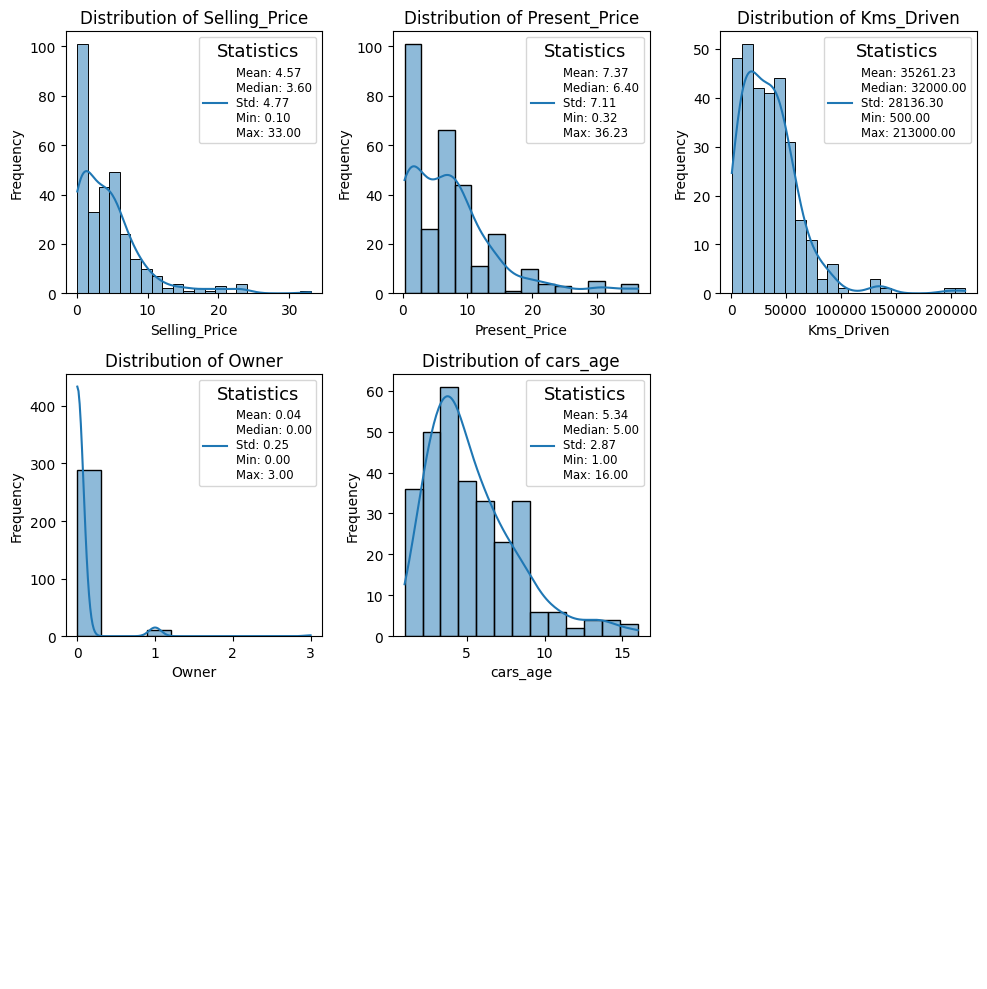

In [200]:
#Numerical Variables Univariate Analysis - understand underlying patterns for each variable within the dataset 
#mean, median, min val, max val, std
numerical_columns = df1.select_dtypes(include = ['number']).columns.to_list()

fix, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df1[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    min_value = df1[col].min()
    max_value = df1[col].max()
    mean_value = np.mean(df1[col])
    std_value = np.std(df1[col])
    median_value = np.median(df1[col])
    
    legend_text = (f'Mean: {mean_value:.2f}\n'
                   f'Median: {median_value:.2f}\n'
                   f'Std: {std_value:.2f}\n'
                   f'Min: {min_value:.2f}\n'
                   f'Max: {max_value:.2f}')
    axes[i].legend([legend_text], loc='upper right', fontsize='small', title='Statistics', title_fontsize='13')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

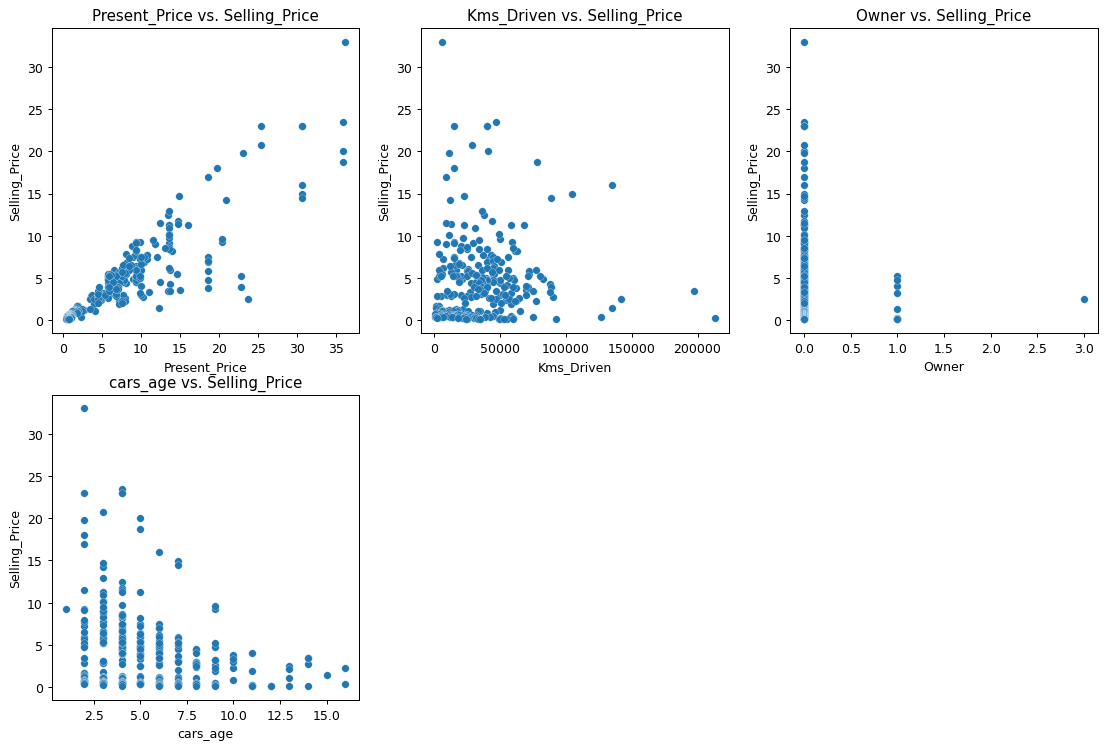

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [201]:
#Target vs. Numerical Features Bivariate Analysis - Compare Indepdent variable relationship to dependent variable
target = 'Selling_Price'
numerical_cols = df1.select_dtypes(include=['number']).columns
numerical_cols = [col for col in numerical_cols if col != target]  # Exclude target column

fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=90)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=df1[col], y=df1[target], ax=axes[i], linewidth=0.2)
    plt.figure(figsize=(5, 5))
    axes[i].set_title(f'{col} vs. {target}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
#present price goes up with selling price
#More KMS Driven, lower price 
#Price of Car decreases as age increases

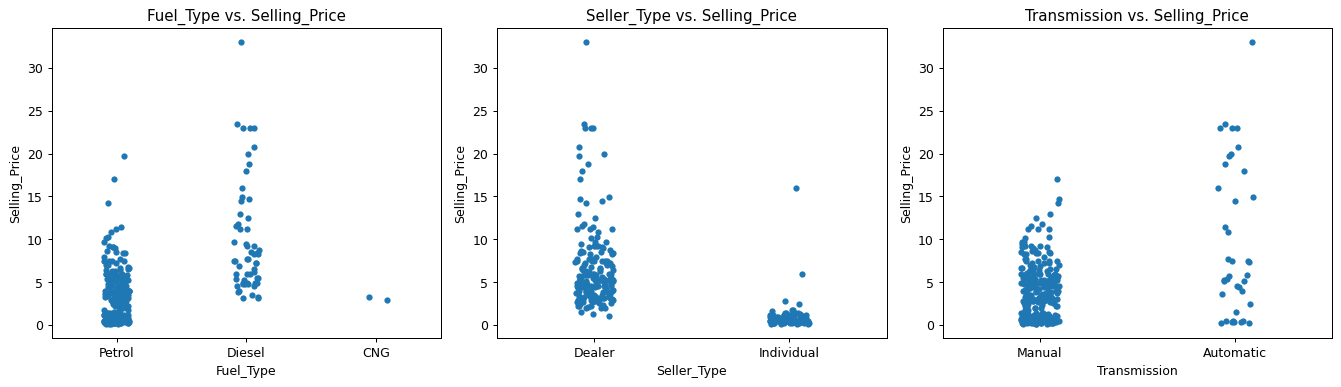

In [202]:
#Target vs. Categorical Features Bivariate Analysis
target = 'Selling_Price'
cat_cols = df1.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col != target]

fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=90)
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.stripplot(x=df1[col], y=df1[target], ax=axes[i])
    axes[i].set_title(f'{col} vs. {target}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    
    
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

#Diesel cars are more expensive than Petrol cars
#Selling prices of cars sold by dealers is higher than individuals
#Automatic cars are more expensive than manual

In [203]:
#Multivariate Analysis

In [204]:
#One Hot Encoding
cat_cols = df1.select_dtypes(include=['object'])

one_hot = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoded = one_hot.fit_transform(cat_cols)

encoded_df = pd.DataFrame(encoded, columns=one_hot.get_feature_names_out(cat_cols.columns))
df1 = df1.drop(columns=cat_cols.columns)
df1 = pd.concat([df1, encoded_df], axis=1)
df1.head(3)

,Selling_Price,Present_Price,Kms_Driven,Owner,cars_age,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual
0,3.35,5.59,27000.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,4.75,9.54,43000.0,0.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,7.25,9.85,6900.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [205]:
#Corr Matrix
corr_matrix = df1.corr()
target_corr = corr_matrix['Selling_Price'].sort_values(ascending=False)
target_corr

Selling_Price             1.000000
Present_Price             0.883903
Seller_Type_Dealer        0.549707
Fuel_Type_Diesel          0.387573
Transmission_Automatic    0.379616
Kms_Driven                0.062810
Fuel_Type_CNG            -0.025011
Owner                    -0.091101
cars_age                 -0.275162
Fuel_Type_Petrol         -0.377715
Transmission_Manual      -0.379616
Seller_Type_Individual   -0.549707
Name: Selling_Price, dtype: float64

<Axes: >

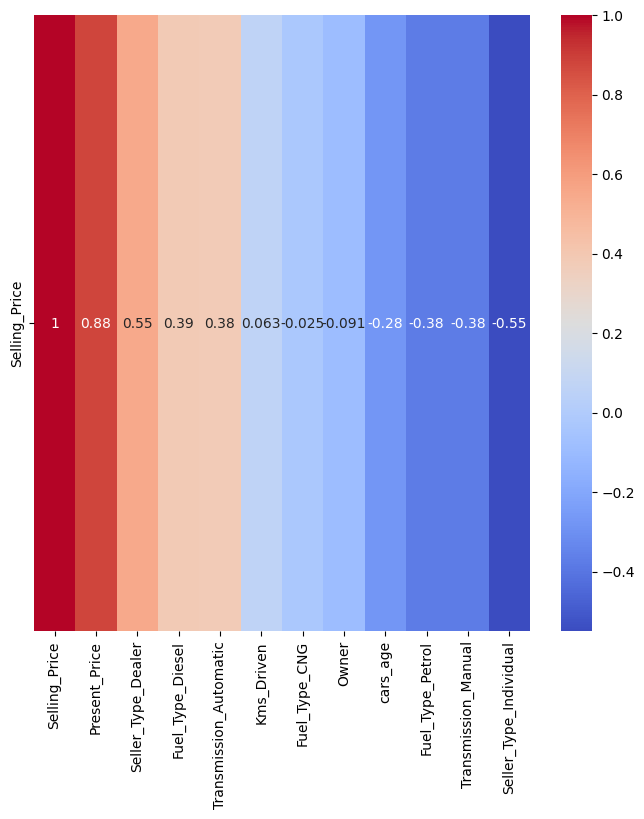

In [206]:
plt.figure(figsize=(8, 8))
sns.heatmap(target_corr.to_frame().transpose(), annot=True, cmap='coolwarm')

# Model Building

In [207]:
df1 = df1.dropna(subset=['Selling_Price']) #drop null values for price

In [208]:
X = df1.drop('Selling_Price', axis = 1)
y = df1['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [209]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(209, 11) (209,) (90, 11) (90,)


In [210]:
y_test_actual = y_test

In [211]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [212]:
#must only use data from train set for scaling
scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [213]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [214]:
regressor.coef_, regressor.intercept_

(array([ 4.19854792, -0.74535225, -0.32529183, -0.70751759, -0.07973131,
         0.02432663, -0.00467363,  0.11654443, -0.11654443, -0.05594429,
         0.05594429]),
 4.37622009569378)

In [215]:
def evaluate_predictions(X_test_scaled, y_test):
    y_pred = regressor.predict(X_test_scaled)
    
    MSE = np.mean(np.square(y_test - y_pred))
    MAE = np.mean(np.abs(y_test - y_pred))
    RMSE = np.sqrt(MSE)
    R2_score = r2_score(y_test, y_pred)
    
    return MSE, MAE, RMSE, R2_score

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test_scaled, y_test)
print(f'MSE: {MSE}, MAE: {MAE}, RMSE:{RMSE}, R2:{R2_score}')

MSE: 4.594326225771336, MAE: 1.417312474608617, RMSE:2.1434379453978454, R2:0.8392629516799028


# Cross Validation and Learning Curves

In [228]:
#K fold cross validation
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())

])

def rmse(y_pred, y_test):
    return np.sqrt((mean_squared_error(y_test, y_pred)))

scoring = {
    'MSE': make_scorer(mean_squared_error), 
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(rmse), 
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=None)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)
# for k, v in cv_results.items(): print(k, v)

mse, mae, rmse, r2 = cv_results['test_MSE'], cv_results['test_MAE'], cv_results['test_RMSE'], cv_results['test_R2']
print(f'MSE: {np.mean(mse)}, MAE: {np.mean(mae)}, RMSE:{np.mean(rmse)}, R2:{np.mean(r2)}')

MSE: 3.303448382951322, MAE: 1.1456267959849868, RMSE:1.7688201255418345, R2:0.8533145793529371


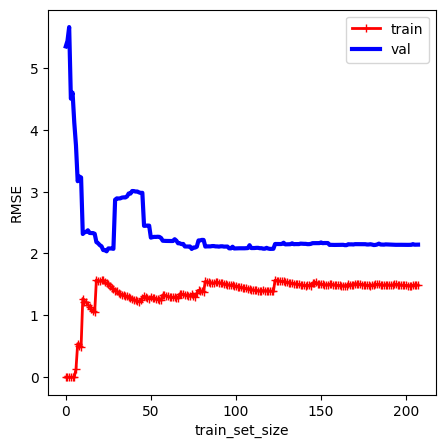

In [235]:
def plot_learning_curve(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    for i in range(1, len(X_train)):
        pipeline.fit(X_train[:i], y_train[:i])
        y_train_predict = pipeline.predict(X_train[:i])
        y_val_predict = pipeline.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:i], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize=(5, 5))
    plt.xlabel('train_set_size')
    plt.ylabel('RMSE')
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend()
    plt.show()
plot_learning_curve(X, y)

#error on training data starts low but as training instances are added, error goes up and plateaus
#validation error is large due to small number of instances (incapable of generalizing properly) - as it learns though, error goes down but is plateauing.
#underfitting, as data is not linear

# Regression Line Plot

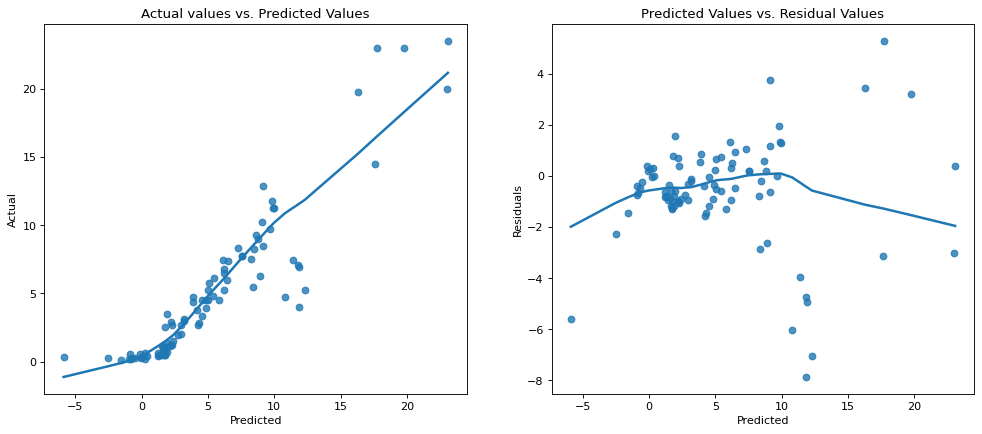

In [229]:
def residuals(regressor, X_test_scaled, y_test):
    y_pred = regressor.predict(X_test_scaled)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', lowess=True, data=df_results, ax = ax[0])
    ax[0].set_title('Actual values vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.regplot(x='Predicted', y='Residuals', lowess=True, data=df_results, ax=ax[1])
    ax[1].set_title('Predicted Values vs. Residual Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
residuals(regressor, X_test_scaled, y_test)
#non linear line - introduce polynomial features or nonlinear transforms